In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

In [2]:
num_classes = 10

learning_rate = 0.001
epochs = 200
batch_size = 128
display_step = 10

In [3]:
def cross_entropy_loss(x, y):
    y = tf.cast(y, tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    return tf.reduce_mean(loss)


def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [4]:
def run_optimization(x, y, model, optimizer):
    with tf.GradientTape() as g:
        pred = model(x, is_training=True)
        loss = cross_entropy_loss(pred, y)
        
    trainable_variables = model.trainable_variables

    gradients = g.gradient(loss, trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# ნორმალიზება
x_train, x_test = x_train / 255., x_test / 255.

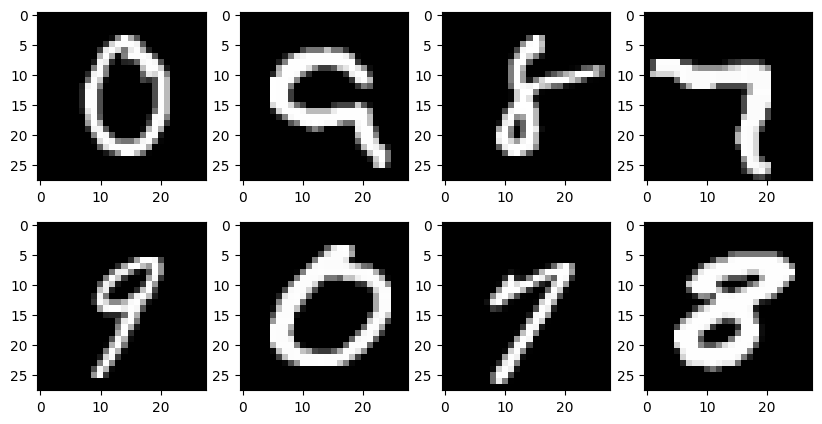

In [6]:
fig, axs = plt.subplots(2, 4, figsize = (10, 5))
for r in axs:
    for ax in r:
        ax.imshow(x_train[np.random.randint(0, len(x_train))], cmap='gray')

#### CNN

In [7]:
conv1_filters = 32
conv2_filters = 64
fc1_units = 1024

In [8]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [9]:
class ConvNet(Model):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = layers.Conv2D(32, kernel_size=5, activation=tf.nn.relu)
        self.maxpool1 = layers.MaxPool2D(2, strides=2)

        self.conv2 = layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu)
        self.maxpool2 = layers.MaxPool2D(2, strides=2)

        self.flatten = layers.Flatten()

        self.fc1 = layers.Dense(1024)
        self.dropout = layers.Dropout(rate=0.5)

        self.out = layers.Dense(num_classes)

    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training=is_training)
        x = self.out(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

conv_net = ConvNet()

In [10]:
optimizer = tf.optimizers.Adam(learning_rate)

cnn_losses = []
cnn_accs = []
for step, (batch_x, batch_y) in enumerate(train_data.take(epochs), 1):
    run_optimization(batch_x, batch_y, conv_net, optimizer)
    
    if step % display_step == 0 or step == 1:
        pred = conv_net(batch_x)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        cnn_losses.append(loss)
        cnn_accs.append(acc)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 1, loss: 2.238530, accuracy: 0.187500
step: 10, loss: 1.926826, accuracy: 0.796875
step: 20, loss: 1.623775, accuracy: 0.898438
step: 30, loss: 1.536328, accuracy: 0.968750
step: 40, loss: 1.554991, accuracy: 0.929688
step: 50, loss: 1.544818, accuracy: 0.960938
step: 60, loss: 1.567107, accuracy: 0.929688
step: 70, loss: 1.508344, accuracy: 0.984375
step: 80, loss: 1.509593, accuracy: 0.984375
step: 90, loss: 1.523603, accuracy: 0.960938
step: 100, loss: 1.502805, accuracy: 0.976562
step: 110, loss: 1.522833, accuracy: 0.960938
step: 120, loss: 1.524964, accuracy: 0.953125
step: 130, loss: 1.505249, accuracy: 0.960938
step: 140, loss: 1.511416, accuracy: 0.960938
step: 150, loss: 1.510506, accuracy: 0.968750
step: 160, loss: 1.513188, accuracy: 0.953125
step: 170, loss: 1.500968, accuracy: 0.960938
step: 180, loss: 1.519964, accuracy: 0.945312
step: 190, loss: 1.500576, accuracy: 0.976562
step: 200, loss: 1.521651, accuracy: 0.968750


In [11]:
pred = conv_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))
print("Test Loss: %f" % cross_entropy_loss(pred, y_test))

Test Accuracy: 0.982000
Test Loss: 1.493100


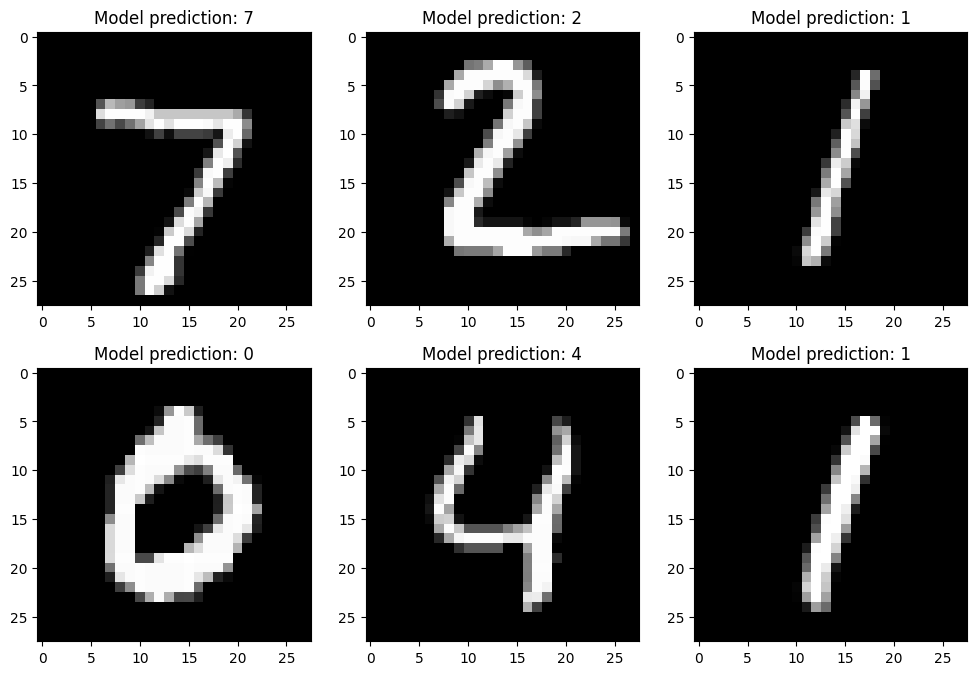

In [12]:
plot_dims = (2, 3)
n_images = plot_dims[0] * plot_dims[1]
test_images = x_test[:n_images]
predictions = conv_net(test_images)

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

for i in range(n_images):
    axs[i].imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    axs[i].set_title("Model prediction: %i" % np.argmax(predictions.numpy()[i]))

### RNN

In [13]:
num_input = 28
timesteps = 28
num_units = 32

In [14]:
num_features = 28*28

x_train, x_test = x_train.reshape([-1, 28, 28]), x_test.reshape([-1, 28, 28])

In [15]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [16]:
class LSTM(Model):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm_layer = layers.LSTM(units=num_units)
        self.out = layers.Dense(num_classes)

    def call(self, x, is_training=False):
        x = self.lstm_layer(x)
        x = self.out(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

lstm_net = LSTM()

In [17]:
optimizer = tf.optimizers.Adam(learning_rate)

rnn_losses = []
rnn_accs = []
for step, (batch_x, batch_y) in enumerate(train_data.take(epochs), 1):
    run_optimization(batch_x, batch_y, lstm_net, optimizer)
    
    if step % display_step == 0 or step == 1:
        pred = lstm_net(batch_x, is_training=True)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        rnn_losses.append(loss)
        rnn_accs.append(acc)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 1, loss: 2.305995, accuracy: 0.125000
step: 10, loss: 2.261103, accuracy: 0.226562
step: 20, loss: 2.202477, accuracy: 0.320312
step: 30, loss: 2.188947, accuracy: 0.210938
step: 40, loss: 2.088703, accuracy: 0.296875
step: 50, loss: 1.958528, accuracy: 0.406250
step: 60, loss: 1.900005, accuracy: 0.335938
step: 70, loss: 1.550552, accuracy: 0.570312
step: 80, loss: 1.644909, accuracy: 0.476562
step: 90, loss: 1.539606, accuracy: 0.546875
step: 100, loss: 1.435105, accuracy: 0.531250
step: 110, loss: 1.381157, accuracy: 0.593750
step: 120, loss: 1.240795, accuracy: 0.671875
step: 130, loss: 1.199040, accuracy: 0.632812
step: 140, loss: 1.223571, accuracy: 0.609375
step: 150, loss: 1.067810, accuracy: 0.695312
step: 160, loss: 1.099004, accuracy: 0.617188
step: 170, loss: 0.929726, accuracy: 0.750000
step: 180, loss: 0.919346, accuracy: 0.765625
step: 190, loss: 0.818377, accuracy: 0.812500
step: 200, loss: 0.841558, accuracy: 0.765625


In [18]:
pred = lstm_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))
print("Test Loss: %f" % cross_entropy_loss(pred, y_test))

Test Accuracy: 0.721000
Test Loss: 1.896414


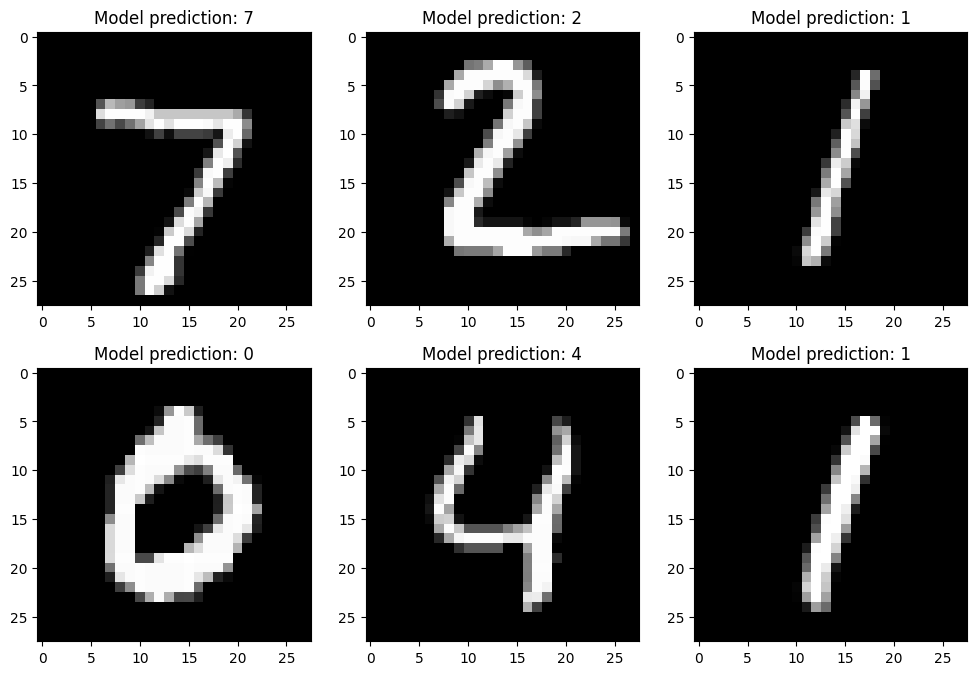

In [19]:
plot_dims = (2, 3)
n_images = plot_dims[0] * plot_dims[1]
test_images = x_test[:n_images]
predictions = lstm_net(test_images)

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

for i in range(n_images):
    axs[i].imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    axs[i].set_title("Model prediction: %i" % np.argmax(predictions.numpy()[i]))

Text(0.5, 1.0, 'სიზუსტის გრაფიკი')

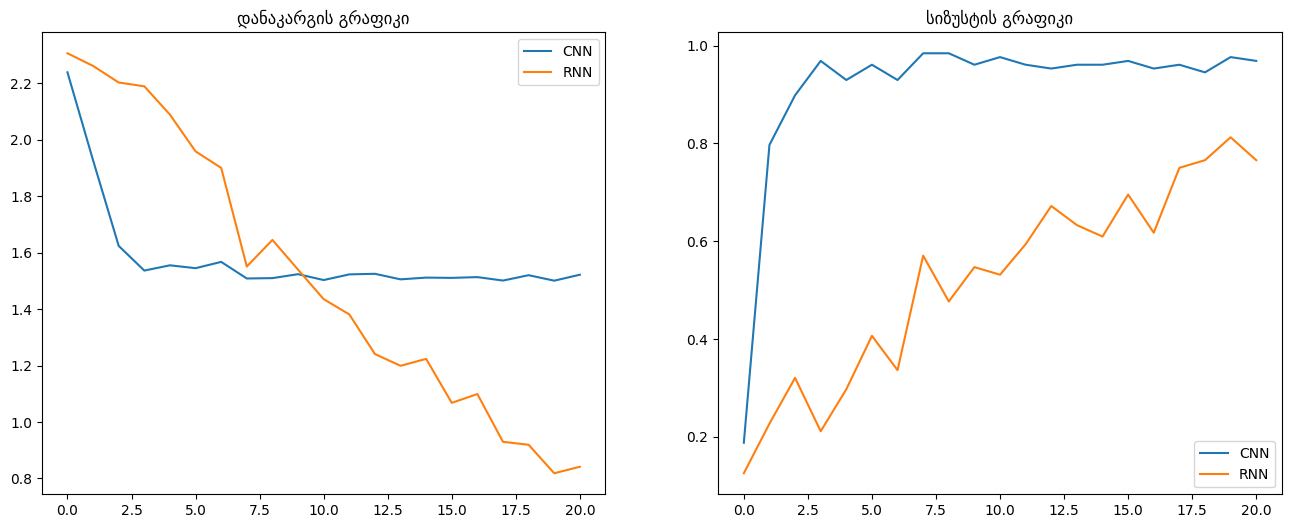

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(cnn_losses, label = "CNN")
ax1.plot(rnn_losses, label = "RNN")
ax1.legend()
ax1.set_title("დანაკარგის გრაფიკი")

ax2.plot(cnn_accs, label = "CNN")
ax2.plot(rnn_accs, label = "RNN")
ax2.legend()
ax2.set_title("სიზუსტის გრაფიკი")